# Requirements

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import plotly.express as px

anscombe = pd.read_csv("anscombe.csv")
sns.set(style="white")
colours = ["orange", "blue", "green", "black"]
print(anscombe)

    x123     y1    y2     y3    x4     y4
0   10.0   8.04  9.14   7.46   8.0   6.58
1    8.0   6.95  8.14   6.77   8.0   5.76
2   13.0   7.58  8.74  12.74   8.0   7.71
3    9.0   8.81  8.77   7.11   8.0   8.84
4   11.0   8.33  9.26   7.81   8.0   8.47
5   14.0   9.96  8.10   8.84   8.0   7.04
6    6.0   7.24  6.13   6.08   8.0   5.25
7    4.0   4.26  3.10   5.39  19.0  12.50
8   12.0  10.84  9.13   8.15   8.0   5.56
9    7.0   4.82  7.26   6.42   8.0   7.91
10   5.0   5.68  4.74   5.73   8.0   6.89


# Making the CSV usable

In [2]:
anscombe_melted = anscombe.melt(
    id_vars=["x123","x4"], 
    value_vars=["y1","y2","y3","y4"],
    var_name="dataset",
    value_name="y"
)
anscombe_melted["dataset"] = anscombe_melted["dataset"].replace({
    "y1": "I",
    "y2": "II",
    "y3": "III",
    "y4": "IV"
})

anscombe_melted["x"] = anscombe_melted.apply(lambda row: row["x123"] if row["dataset"] in ["I","II","III"] else row["x4"], axis=1)

anscombe_melted = anscombe_melted.drop(columns=["x123","x4"])
print(anscombe_melted)

   dataset      y     x
0        I   8.04  10.0
1        I   6.95   8.0
2        I   7.58  13.0
3        I   8.81   9.0
4        I   8.33  11.0
5        I   9.96  14.0
6        I   7.24   6.0
7        I   4.26   4.0
8        I  10.84  12.0
9        I   4.82   7.0
10       I   5.68   5.0
11      II   9.14  10.0
12      II   8.14   8.0
13      II   8.74  13.0
14      II   8.77   9.0
15      II   9.26  11.0
16      II   8.10  14.0
17      II   6.13   6.0
18      II   3.10   4.0
19      II   9.13  12.0
20      II   7.26   7.0
21      II   4.74   5.0
22     III   7.46  10.0
23     III   6.77   8.0
24     III  12.74  13.0
25     III   7.11   9.0
26     III   7.81  11.0
27     III   8.84  14.0
28     III   6.08   6.0
29     III   5.39   4.0
30     III   8.15  12.0
31     III   6.42   7.0
32     III   5.73   5.0
33      IV   6.58   8.0
34      IV   5.76   8.0
35      IV   7.71   8.0
36      IV   8.84   8.0
37      IV   8.47   8.0
38      IV   7.04   8.0
39      IV   5.25   8.0
40      IV  12.5

# Summary Stats

In [3]:
def dataset_stats(df, name):
    x = df["x"]
    y = df["y"]
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0, 1]
    corr = np.corrcoef(x, y)[0, 1]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    r_squared = r_value**2
    
    return {
        "Dataset": name,
        "Mean x": round(mean_x, 2),
        "Mean y": round(mean_y, 2),
        "Var x": round(var_x, 2),
        "Var y": round(var_y, 2),
        "Std x": round(std_x, 2),
        "Std y": round(std_y, 2),
        "Cov xy": round(cov_xy, 2),
        "Correlation": round(corr, 3),
        "Slope": round(slope, 3),
        "Intercept": round(intercept, 3),
        "R²": round(r_squared, 3)
    }

results = []
for dataset_name, group in anscombe_melted.groupby("dataset"):
    results.append(dataset_stats(group, dataset_name))
    
stats_df = pd.DataFrame(results)

print(stats_df.set_index("Dataset").T)

Dataset           I      II     III      IV
Mean x        9.000   9.000   9.000   9.000
Mean y        7.500   7.500   7.500   7.500
Var x        11.000  11.000  11.000  11.000
Var y         4.130   4.130   4.120   4.120
Std x         3.320   3.320   3.320   3.320
Std y         2.030   2.030   2.030   2.030
Cov xy        5.500   5.500   5.500   5.500
Correlation   0.816   0.816   0.816   0.817
Slope         0.500   0.500   0.500   0.500
Intercept     3.000   3.001   3.002   3.002
R²            0.667   0.666   0.666   0.667


# Scatter + regression line (seaborn) - one figure per dataset

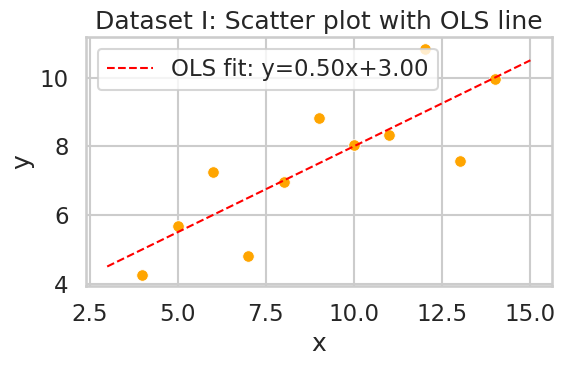

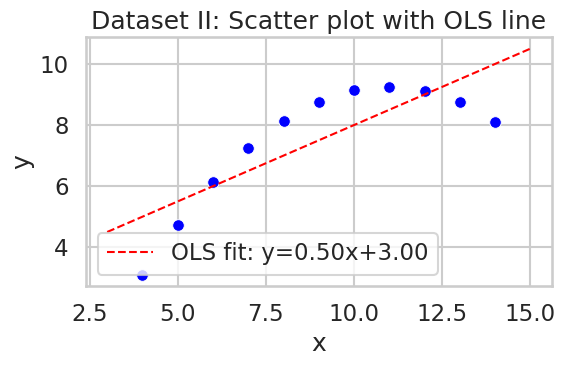

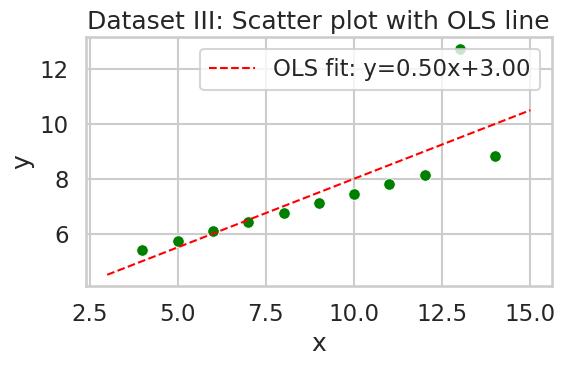

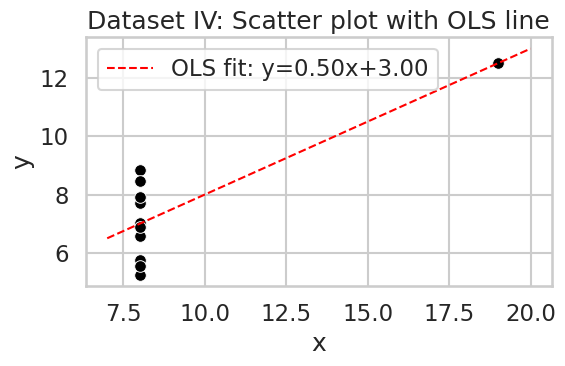

In [4]:
sns.set(style="whitegrid", context="talk")
for (name, group), colour in zip(anscombe_melted.groupby('dataset'), colours):
    plt.figure(figsize=(6,4))
    ax = sns.scatterplot(data=group, x='x', y='y', s=70, color=colour)
    
    X = sm.add_constant(group['x'])
    model = sm.OLS(group['y'], X).fit()
    xs = np.linspace(group['x'].min() - 1, group['x'].max() + 1, 100)
    ys = model.params['const'] + model.params['x'] * xs
    plt.plot(xs, ys, linestyle='--', linewidth=1.5, color="red",
             label=f"OLS fit: y={model.params['x']:.2f}x+{model.params['const']:.2f}")
    plt.title(f"Dataset {name}: Scatter plot with OLS line")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"scatter_reg_rayan_{name}.png", dpi=200)

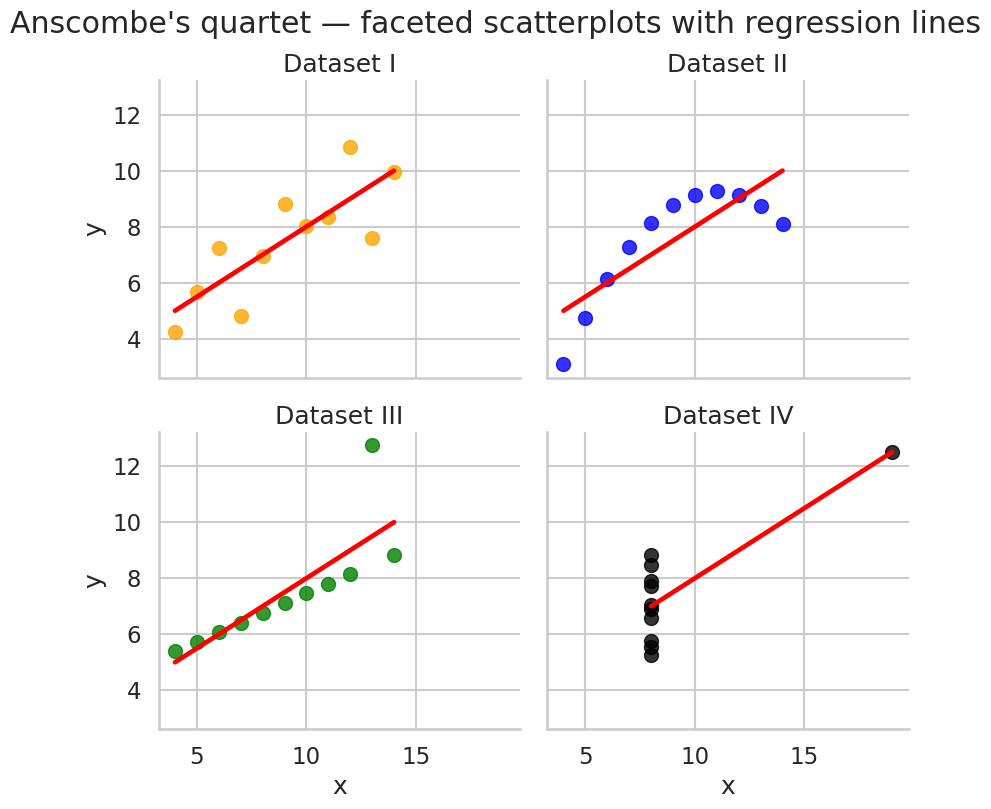

In [5]:
g = sns.lmplot(
    data=anscombe_melted,
    x="x",
    y="y",
    col="dataset",
    col_wrap=2,
    ci=None,
    height=4,
    aspect=1.1,
    scatter_kws={"s":100}
)

titles = ["Dataset I", "Dataset II", "Dataset III", "Dataset IV"]

for ax, title, colour in zip(g.axes, titles, colours):
    ax.set_title(title)

    for collection in ax.collections:
        collection.set_facecolor(colour)
        collection.set_edgecolor(colour)

    ax.lines[0].set_color("red")

plt.suptitle("Anscombe's quartet — faceted scatterplots with regression lines", y=1.02)
g.savefig(f"resid_rayan.png", dpi=200)


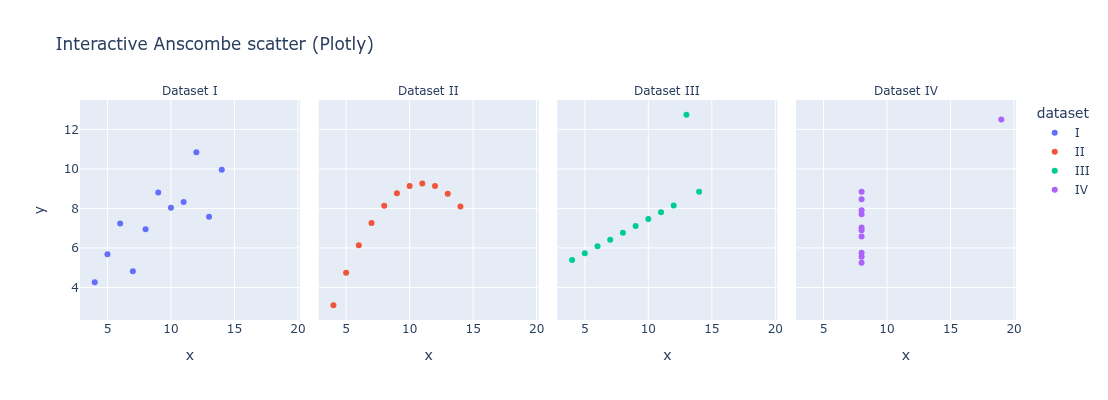

In [11]:
fig = px.scatter(
    anscombe_melted,
    x='x', y='y',
    color='dataset',
    facet_col='dataset',
    title="Interactive Anscombe scatter (Plotly)"
)
fig.update_layout(height=400, width=1000)

new_titles = {"I": "Dataset I", "II": "Dataset II", "III": "Dataset III", "IV": "Dataset IV"}
fig.for_each_annotation(lambda a: a.update(text=new_titles[a.text.split("=")[-1].strip()]))

fig.show()
